In [35]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import keras
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.optimizers import Adam
import pickle


In [36]:
def pca_analysis(X_train, hs = [1, 2, 3, 4] ):
    dict_pca = {}
    dict_e_pca_train = {}
    dict_var_exp_train = {}
    dict_e_pca_test = {}


    for h in hs:
        dict_pca[h] = PCA(n_components = h)
        dict_pca[h].fit(X_train)
        pca = dict_pca[h]
        Z_train = pca.transform(X_train)
        Xtilde_train = pca.inverse_transform(Z_train)
        e_pca_train = mean_squared_error(X_train, Xtilde_train)
        var_exp_train = np.sum(pca.explained_variance_ratio_)
        dict_e_pca_train[h] = e_pca_train
        dict_var_exp_train[h] = var_exp_train
        Z_test = pca.transform(X_test)
        Xtilde_test = pca.inverse_transform(Z_test)
        e_pca_test = mean_squared_error(X_test, Xtilde_test)
        dict_e_pca_test[h] = e_pca_test
        print("SKL PCA, h =", h, "PCs, reconstruction error:", str(round(e_pca_train, 4)),
              "total ratio of variance explained:", str(round(var_exp_train, 4)))
        
    return

In [37]:
df = pd.read_csv('features_random_100k_ns60_pf0.5_vi2_vf40_si50_sf250')
#df = pd.read_csv('features_random_8k_60_60_v_2_30')

In [38]:
def prepare_data(df, test_size = 0.15):
    Y = df['c']
    #X = df.iloc[:,1:]

    X_train, X_test, Y_train, Y_test = train_test_split(df, Y, 
                                                        shuffle = True, 
                                                        test_size = test_size, random_state=10)
    SR_moment_train = X_train['c_moment']/X_train['std_moment']
    SR_moment_test = X_test['c_moment']/X_test['std_moment']
    
    X_train = X_train[['v' , 'n', 'R-', 'R+']]
    X_test = X_test[['v' , 'n', 'R-', 'R+']]
    
    return X_train, X_test, Y_train, Y_test, SR_moment_test

In [39]:
X_train, X_test, Y_train, Y_test, SR_moment_test = prepare_data(df)

## Let's apply PCA to see whether the features space can have its dimension reduced in order to avoid overfitting

In [40]:
pca_analysis(X_train)

SKL PCA, h = 1 PCs, reconstruction error: 226.7379 total ratio of variance explained: 0.8657
SKL PCA, h = 2 PCs, reconstruction error: 30.0737 total ratio of variance explained: 0.9822
SKL PCA, h = 3 PCs, reconstruction error: 0.0775 total ratio of variance explained: 1.0
SKL PCA, h = 4 PCs, reconstruction error: 0.0 total ratio of variance explained: 1.0


In [41]:
#plt.plot(dict_pca[3].components_[2], 'x')

### Let's normalize the features

In [42]:
scaler = StandardScaler().fit(X_train)
X_train_n = scaler.transform(X_train)
X_test_n = scaler.transform(X_test)
X_test_n = pd.DataFrame(X_test_n, columns=X_test.columns)

In [43]:
pca_analysis(X_train_n)

SKL PCA, h = 1 PCs, reconstruction error: 0.5184 total ratio of variance explained: 0.4816
SKL PCA, h = 2 PCs, reconstruction error: 0.2635 total ratio of variance explained: 0.7365
SKL PCA, h = 3 PCs, reconstruction error: 0.0165 total ratio of variance explained: 0.9835
SKL PCA, h = 4 PCs, reconstruction error: 0.0 total ratio of variance explained: 1.0


In [22]:
# Saving the Scaler
filename = 'scaler_2to30'
pickle.dump(scaler, open(filename, 'wb'))

In [23]:
#filename = 'scaler_2to30'
#loaded_model = pickle.load(open(filename, 'rb'))
#X2_n = scaler.transform(X2)
#X_test_n = loaded_model.transform(X_test)

In [53]:
m = Sequential()
m.add(Dense(20,  activation='relu', input_shape=(4,)))
#m.add(Dense(30,  activation='relu'))
#m.add(Dense(30,  activation='relu')) 
m.add(Dense(20,  activation='relu')) 
m.add(Dense(15,  activation='relu')) 
m.add(Dense(10,  activation='relu'))
m.add(Dense(10,  activation='relu'))
m.add(Dense(5,  activation='relu'))
m.add(Dense(3,  activation='relu'))
m.add(Dense(1,  activation='linear'))
m.compile(loss='mean_squared_error', optimizer = Adam(), metrics=['mape'])

#history = m.fit(X_train_n, Y_train, batch_size=10, epochs=20, verbose=1, validation_data = (X_test_n, Y_test))

history = m.fit(X_train_n, Y_train, epochs=150, verbose=1, validation_data = (X_test_n, Y_test))

Train on 85000 samples, validate on 15000 samples
Epoch 1/150
85000/85000 [==============================] - 4s 52us/step - loss: 0.0341 - mean_absolute_percentage_error: 9.0592 - val_loss: 0.0023 - val_mean_absolute_percentage_error: 4.1124
Epoch 2/150
85000/85000 [==============================] - 3s 37us/step - loss: 0.0021 - mean_absolute_percentage_error: 3.6827 - val_loss: 0.0030 - val_mean_absolute_percentage_error: 4.4488
Epoch 3/150
85000/85000 [==============================] - 3s 38us/step - loss: 0.0017 - mean_absolute_percentage_error: 3.3469 - val_loss: 0.0016 - val_mean_absolute_percentage_error: 3.1289
Epoch 4/150
85000/85000 [==============================] - 3s 32us/step - loss: 0.0016 - mean_absolute_percentage_error: 3.2155 - val_loss: 0.0012 - val_mean_absolute_percentage_error: 2.8927
Epoch 5/150
85000/85000 [==============================] - 2s 28us/step - loss: 0.0014 - mean_absolute_percentage_error: 3.0481 - val_loss: 0.0015 - val_mean_absolute_percentage_erro

85000/85000 [==============================] - 3s 38us/step - loss: 8.4790e-04 - mean_absolute_percentage_error: 2.4055 - val_loss: 7.0806e-04 - val_mean_absolute_percentage_error: 2.2201
Epoch 43/150
85000/85000 [==============================] - 3s 40us/step - loss: 8.2293e-04 - mean_absolute_percentage_error: 2.3915 - val_loss: 6.9805e-04 - val_mean_absolute_percentage_error: 2.2065
Epoch 44/150
85000/85000 [==============================] - 4s 43us/step - loss: 8.5360e-04 - mean_absolute_percentage_error: 2.3946 - val_loss: 7.9890e-04 - val_mean_absolute_percentage_error: 2.5455
Epoch 45/150
85000/85000 [==============================] - 4s 41us/step - loss: 8.2789e-04 - mean_absolute_percentage_error: 2.3854 - val_loss: 6.8062e-04 - val_mean_absolute_percentage_error: 2.2203
Epoch 46/150
85000/85000 [==============================] - 3s 41us/step - loss: 8.2152e-04 - mean_absolute_percentage_error: 2.3839 - val_loss: 6.5269e-04 - val_mean_absolute_percentage_error: 2.2277
Epoch 47

Epoch 83/150
85000/85000 [==============================] - 3s 32us/step - loss: 7.3930e-04 - mean_absolute_percentage_error: 2.3098 - val_loss: 6.8946e-04 - val_mean_absolute_percentage_error: 2.3797
Epoch 84/150
85000/85000 [==============================] - 2s 29us/step - loss: 7.6213e-04 - mean_absolute_percentage_error: 2.3229 - val_loss: 7.1224e-04 - val_mean_absolute_percentage_error: 2.2545
Epoch 85/150
85000/85000 [==============================] - 2s 29us/step - loss: 7.5355e-04 - mean_absolute_percentage_error: 2.3195 - val_loss: 8.5928e-04 - val_mean_absolute_percentage_error: 2.4229
Epoch 86/150
85000/85000 [==============================] - 3s 31us/step - loss: 7.6156e-04 - mean_absolute_percentage_error: 2.3239 - val_loss: 9.3402e-04 - val_mean_absolute_percentage_error: 2.3836
Epoch 87/150
85000/85000 [==============================] - 3s 33us/step - loss: 7.3539e-04 - mean_absolute_percentage_error: 2.2905 - val_loss: 6.8128e-04 - val_mean_absolute_percentage_error: 2.

Epoch 124/150
85000/85000 [==============================] - 3s 34us/step - loss: 6.9468e-04 - mean_absolute_percentage_error: 2.2552 - val_loss: 7.7739e-04 - val_mean_absolute_percentage_error: 2.3003
Epoch 125/150
85000/85000 [==============================] - 3s 34us/step - loss: 6.9295e-04 - mean_absolute_percentage_error: 2.2619 - val_loss: 7.3516e-04 - val_mean_absolute_percentage_error: 2.3003
Epoch 126/150
85000/85000 [==============================] - 3s 32us/step - loss: 6.9930e-04 - mean_absolute_percentage_error: 2.2440 - val_loss: 7.5027e-04 - val_mean_absolute_percentage_error: 2.3081
Epoch 127/150
85000/85000 [==============================] - 3s 33us/step - loss: 7.0859e-04 - mean_absolute_percentage_error: 2.2625 - val_loss: 7.3598e-04 - val_mean_absolute_percentage_error: 2.2438
Epoch 128/150
85000/85000 [==============================] - 3s 33us/step - loss: 6.8981e-04 - mean_absolute_percentage_error: 2.2467 - val_loss: 6.2448e-04 - val_mean_absolute_percentage_erro

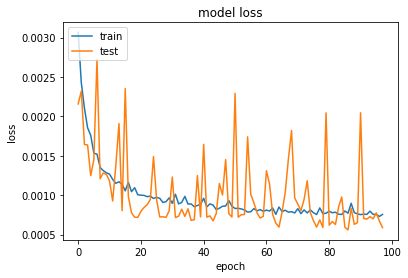

In [51]:
# summarize history for loss
plt.plot(history.history['loss'][2:100])
plt.plot(history.history['val_loss'][2:100])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
# Saving the model
filename = 'NN-v-2-30-MAE-2.41'
pickle.dump(m, open(filename, 'wb'))

In [25]:
filename = 'NN-v-2-30-MAE-2.41'
m = pickle.load(open(filename, 'rb'))

In [45]:
#mean_absolute_error(Y_test, loaded_model.predict(X_test_n))
mean_absolute_error(Y_test, loaded_model.predict(X_test))

NameError: name 'loaded_model' is not defined

## PCA doesnt help a lot

## Analysis of the error in function of the degrees of fredoom v

In [ ]:
def plot_error(model, X_test, Y_test, Y_test_moment, scaler, scatter_plot = True):
    v = np.array(X_test['v'])
    
    if scaler:
        X_test = scaler.transform(X_test)
        
    err = np.array(Y_test)-np.array(model.predict(X_test).squeeze())

    err_moment = np.array(Y_test) - np.array(Y_test_moment)
    
    #error dataframe
    e = pd.DataFrame()
    e['v'] = v
    e['err'] = err
    e['err_moment'] = err_moment
    
    #scatter plot
    if scatter_plot:
        plt.figure(figsize=(12,6))
        plt.plot(v,err, 'o',)
        plt.grid(True)
    
    e['v_round']=np.around(e['v'],decimals=1)
    
    #Plot average by v
    eavg=e.groupby('v_round').mean()
    eavg['err'].plot(label = 'Average Error Record-Based', legend = True)
    eavg['err_moment'].plot(label = 'Average Error Moment-Based', legend = True)
    plt.grid(True)
    
    plt.show()
    
    #Plot standard deviation
    eavg=e.groupby('v_round').std()
    eavg['err'].plot(label = 'Std Error Record-Based', legend = True)
    eavg['err_moment'].plot(label = 'Std Error Moment-Based', legend = True)
    eavg['ratio_std'] = eavg['err_moment']/eavg['err']
    plt.show()
    eavg['ratio_std'].plot(label = 'Record-Based Efficiency', legend = True)
    plt.plot([1]*len(eavg['ratio_std']),'r') #Compare efficiency with 1
    
    plt.grid(True)


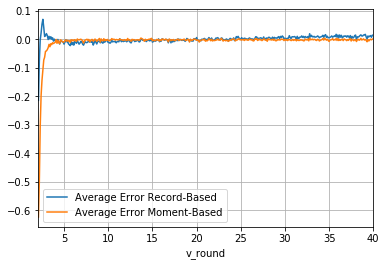

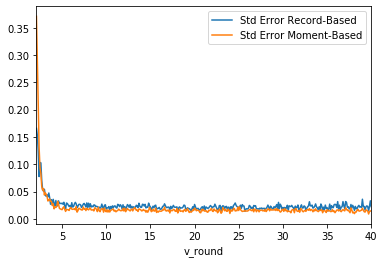

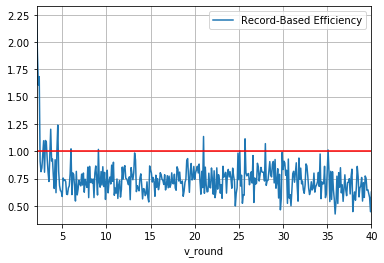

In [33]:
plot_error(m, X_test, Y_test, SR_moment_test, scaler = False, scatter_plot = False)

## The Neural Network has been trained using distributions with the degrees within the interval (2.1 , 30). Let's see how well it performs on data generated using distributions with v within (31,50)

In [28]:
df_41_50 = pd.read_csv('features_random_1k_ns60_pf0.5_vi41_vf60_si50_sf250')

In [29]:
X_train_41_50, X_test_41_50, Y_train_41_50, Y_test_41_50, SR_moment_test_41_50 = prepare_data(df_41_50, test_size=0.999)

In [30]:
len(SR_moment_test_41_50)

999

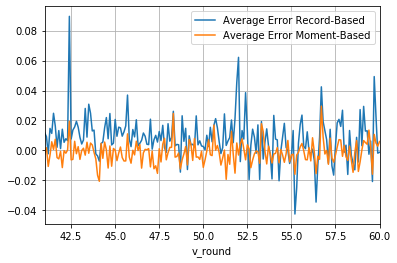

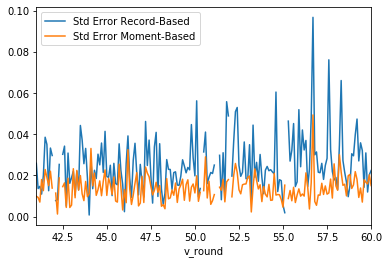

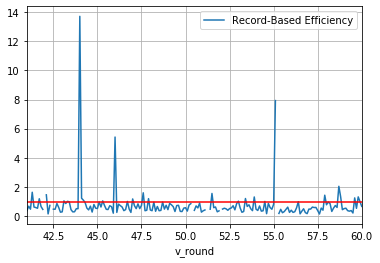

In [34]:
plot_error(m, X_test_41_50, Y_test_41_50,SR_moment_test_41_50,  scaler, scatter_plot = False)